In [23]:
import nltk
from nltk.tokenize import word_tokenize
import spacy
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
import pandas as pd

# Load the dataset
file_path = 'Data-NLP/movie_reviews_v2.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 405.6+ KB


,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0


In [5]:
# Summary of the dataset
data_info = {
    "total_reviews": data.shape[0],
    "rating_distribution": data['rating'].value_counts().sort_index(),
    "null_values": data.isnull().sum()
}

# Creating a new target column based on the specified rating criteria
data['target'] = data['rating'].apply(lambda x: 'high-rating' if x >= 9 else ('low-rating' if x <= 4 else 'exclude'))
filtered_data = data[data['target'] != 'exclude']

data_info['processed_reviews'] = filtered_data.shape[0]
data_info['target_distribution'] = filtered_data['target'].value_counts()

data_info

{'total_reviews': 8650,
 'rating_distribution': 0.5       10
 1.0      284
 1.5        3
 2.0      153
 2.5        2
 3.0      254
 3.5        4
 4.0      514
 4.5        4
 5.0      732
 5.5        6
 6.0     1386
 6.5       22
 7.0     1576
 7.5       27
 8.0     1259
 8.5       23
 9.0      616
 9.5       15
 10.0     564
 Name: rating, dtype: int64,
 'null_values': review_id            0
 movie_id             0
 imdb_id              0
 original_title       0
 review               0
 rating            1196
 target               0
 dtype: int64,
 'processed_reviews': 2419,
 'target_distribution': low-rating     1224
 high-rating    1195
 Name: target, dtype: int64}

In [7]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])  # Disable named entity recognizer for faster processing
nlp.remove_pipe('ner')

# English stopwords
stop_words = set(stopwords.words('english'))

# Function to clean and process text
def process_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Lemmatize
    lemmas = [token.lemma_ for token in nlp(" ".join(tokens))]
    return tokens, lemmas

# Applying the processing function to the dataset
filtered_data['tokens'], filtered_data['lemmas'] = zip(*filtered_data['review'].apply(process_text))

# Joining tokens and lemmas back to strings
filtered_data['tokens_joined'] = filtered_data['tokens'].apply(lambda x: ' '.join(x))
filtered_data['lemmas_joined'] = filtered_data['lemmas'].apply(lambda x: ' '.join(x))

filtered_data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
C:\Users\austi\AppData\Local\Temp\ipykernel_12768\3030529381.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['tokens'], filtered_data['lemmas'] = zip(*filtered_data['review'].apply(process_text))
C:\Users\austi\AppData\Local\Temp\ipykernel_12768\3030529381.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,review_id,movie_id,imdb_id,original_title,review,rating,target,tokens,lemmas,tokens_joined,lemmas_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,high-rating,"[A, guilty, pleasure, personally, I, love, Gre...","[a, guilty, pleasure, personally, I, love, Gre...",A guilty pleasure personally I love Great Esca...,a guilty pleasure personally I love Great Esca...
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,low-rating,"[The, first, underwhelmed, one, bored, Again, ...","[the, first, underwhelme, one, bore, again, co...",The first underwhelmed one bored Again course ...,the first underwhelme one bore again course se...
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,low-rating,"[After, quite, entertainign, Mission, Impossib...","[after, quite, entertainign, Mission, Impossib...",After quite entertainign Mission Impossible I ...,after quite entertainign Mission Impossible I ...
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,high-rating,"[Okay, I, admit, I, bit, easy, grader, comes, ...","[okay, I, admit, I, bite, easy, grader, come, ...",Okay I admit I bit easy grader comes romantic ...,okay I admit I bite easy grader come romantic ...
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,low-rating,"[lackluster, screenplay, unimaginative, kills,...","[lackluster, screenplay, unimaginative, kill, ...",lackluster screenplay unimaginative kills leav...,lackluster screenplay unimaginative kill leave...


In [8]:
import joblib

joblib_file = "Data-NLP/processed_data.joblib"
joblib.dump(data, joblib_file)

['Data-NLP/processed_data.joblib']

In [9]:
# Prep data for Word Cloud
high_rating_text = ' '.join(filtered_data[filtered_data['target'] == 'high-rating']['lemmas_joined'])
low_rating_text = ' '.join(filtered_data[filtered_data['target'] == 'low-rating']['lemmas_joined'])

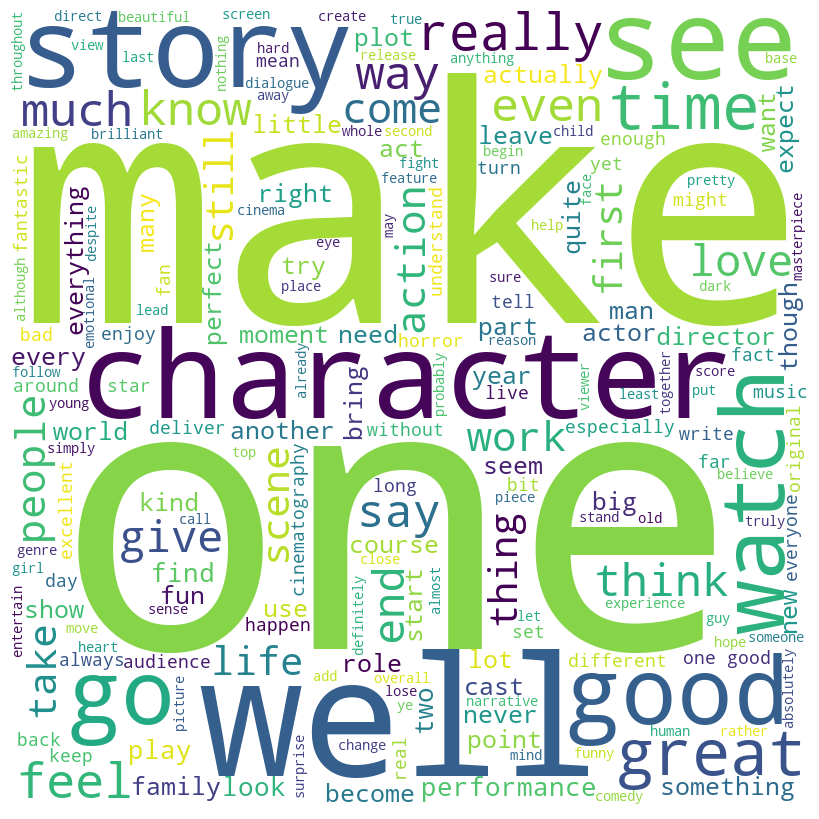

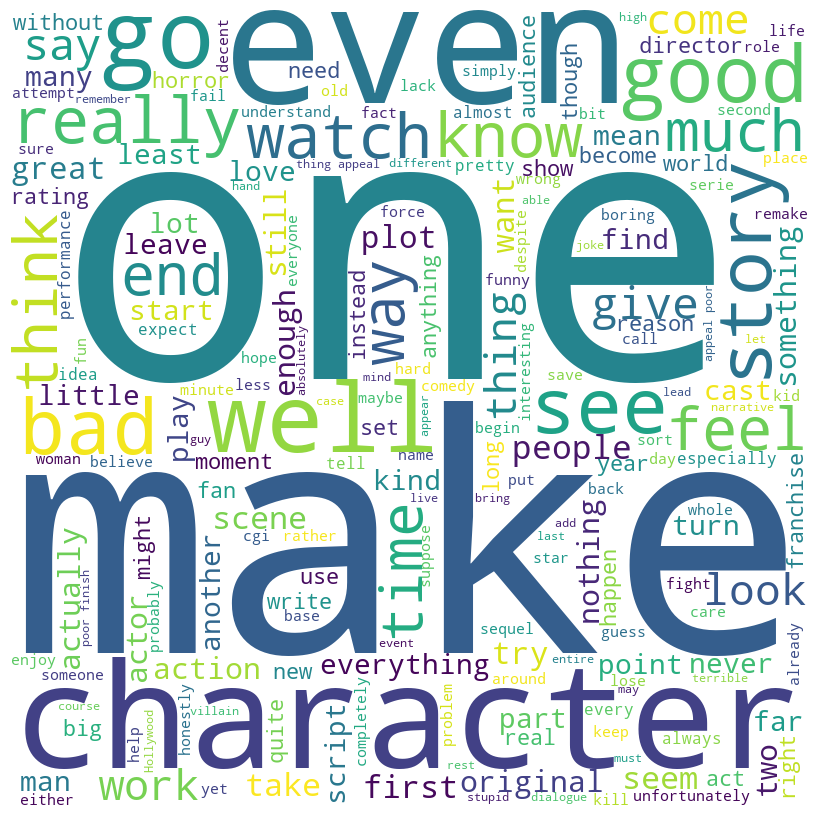

In [13]:
def generate_wordcloud(text, filename, additional_stopwords=set()):
    # Combine default stopwords with any additional ones
    custom_stopwords = STOPWORDS.union(additional_stopwords)

    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          stopwords = custom_stopwords,
                          min_font_size = 10).generate(text)

    # Plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.savefig(f"Images/{filename}.png")
    plt.show()

# Example additional stopwords
additional_stopwords = {'movie', 'film'}

# Generate and save word clouds for each group
generate_wordcloud(high_rating_text, "high_rating_wordcloud", additional_stopwords)
generate_wordcloud(low_rating_text, "low_rating_wordcloud", additional_stopwords)

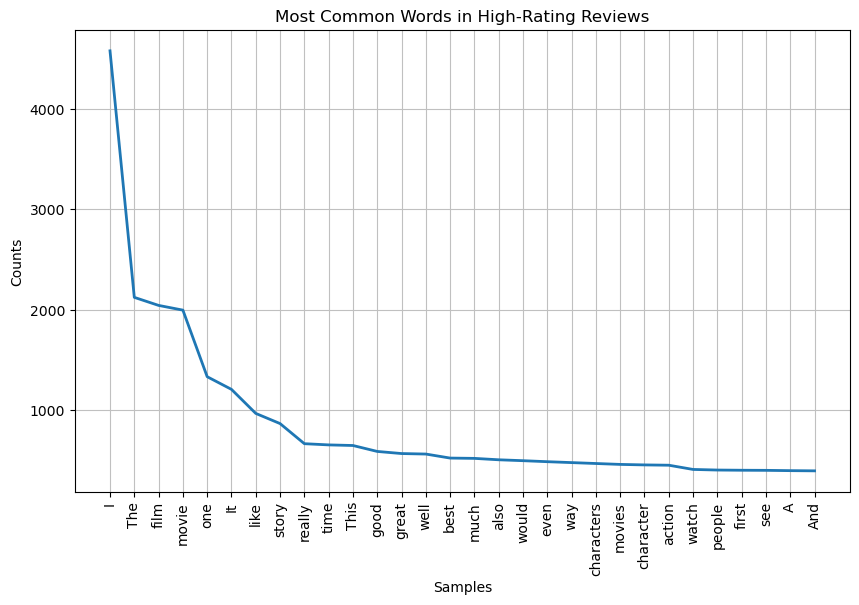

<Figure size 640x480 with 0 Axes>

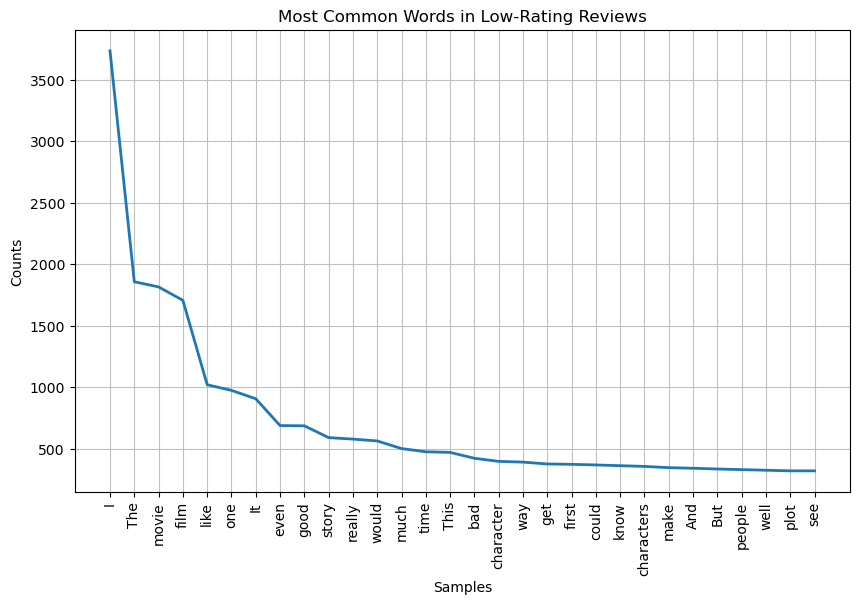

<Figure size 640x480 with 0 Axes>

In [18]:
#FreqDist
high_rating_words = sum(filtered_data[filtered_data['target'] == 'high-rating']['tokens'], [])
low_rating_words = sum(filtered_data[filtered_data['target'] == 'low-rating']['tokens'], [])

from nltk.probability import FreqDist

# Compute the frequency distribution of words for each group
freq_dist_high = FreqDist(high_rating_words)
freq_dist_low = FreqDist(low_rating_words)

def plot_freq_dist(freq_dist, title, filename):
    plt.figure(figsize=(10, 6))
    freq_dist.plot(30, title=title)
    plt.savefig(f"Images/{filename}.png")

plot_freq_dist(freq_dist_high, "Most Common Words in High-Rating Reviews", "high_rating_freq_dist");
plot_freq_dist(freq_dist_low, "Most Common Words in Low-Rating Reviews", "low_rating_freq_dist");

In [26]:
# Custom Function
import pandas as pd
import nltk
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, QuadgramAssocMeasures
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, QuadgramCollocationFinder

def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq=1, words_colname='Words'):
    if ngrams == 4:
        MeasuresClass = QuadgramAssocMeasures
        FinderClass = QuadgramCollocationFinder
    elif ngrams == 3:
        MeasuresClass = TrigramAssocMeasures
        FinderClass = TrigramCollocationFinder
    else:
        MeasuresClass = BigramAssocMeasures
        FinderClass = BigramCollocationFinder

    measures = MeasuresClass()
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)

    if measure == 'pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure = 'raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_", ' ').title()])
    
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

In [32]:
high_reviews_tokens_list = [token for sublist in filtered_data[filtered_data['rating'] >= 9]['tokens'] for token in sublist]
low_reviews_tokens_list = [token for sublist in filtered_data[filtered_data['rating'] <= 4]['tokens'] for token in sublist]

high_rating_ngrams = get_ngram_measures_finder(high_reviews_tokens_list, ngrams=2, measure='pmi', top_n=10, min_freq=3)
low_rating_ngrams = get_ngram_measures_finder(low_reviews_tokens_list, ngrams=2, measure='pmi', top_n=10, min_freq=3)

In [45]:
high_rating_ngrams.to_markdown()

"|    | Words                     |     Pmi |\n|---:|:--------------------------|--------:|\n|  0 | ('Annette', 'Bening')     | 15.7483 |\n|  1 | ('Banshees', 'Inisherin') | 15.7483 |\n|  2 | ('Bone', 'Tomahawk')      | 15.7483 |\n|  3 | ('Corto', 'Maltese')      | 15.7483 |\n|  4 | ('Hansel', 'Gretel')      | 15.7483 |\n|  5 | ('Hildur', 'Guðnadóttir') | 15.7483 |\n|  6 | ('Ice', 'Cube')           | 15.7483 |\n|  7 | ('Imogen', 'Poots')       | 15.7483 |\n|  8 | ('Jaeden', 'Martell')     | 15.7483 |\n|  9 | ('Kemp', 'Powers')        | 15.7483 |"

In [46]:
low_rating_ngrams.to_markdown()

"|    | Words                    |    Pmi |\n|---:|:-------------------------|-------:|\n|  0 | ('Bohemian', 'Rhapsody') | 15.468 |\n|  1 | ('Djimon', 'Hounsou')    | 15.468 |\n|  2 | ('Jared', 'Leto')        | 15.468 |\n|  3 | ('Juliette', 'Danielle') | 15.468 |\n|  4 | ('Lethal', 'Weapon')     | 15.468 |\n|  5 | ('Lorne', 'Balfe')       | 15.468 |\n|  6 | ('Rice', 'Burroughs')    | 15.468 |\n|  7 | ('Solar', 'Opposites')   | 15.468 |\n|  8 | ('Taraji', 'Henson')     | 15.468 |\n|  9 | ('n', 'ga')              | 15.468 |"

In [38]:
# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

filtered_data['sentiment_scores'] = filtered_data['review'].apply(sia.polarity_scores)
filtered_data = pd.concat([filtered_data, filtered_data['sentiment_scores'].apply(pd.Series)], axis=1)
# Filter to get mismatches where high-rating reviews have low compound scores
high_rating_low_sentiment = filtered_data[(filtered_data['target'] == 'high-rating') & (filtered_data['compound'] < 0)]

# Filter to get mismatches where low-rating reviews have high compound scores
low_rating_high_sentiment = filtered_data[(filtered_data['target'] == 'low-rating') & (filtered_data['compound'] > 0)]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\austi\AppData\Local\Temp\ipykernel_12768\2961967324.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['sentiment_scores'] = filtered_data['review'].apply(sia.polarity_scores)


In [44]:
pd.set_option('display.max_colwidth', 500)
# Inspect some examples
print(high_rating_low_sentiment[['review', 'compound']].head())
print(low_rating_high_sentiment[['review', 'compound']].head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  \
22                                                                                                                                                                                                                                                                                                               One of those few movies that most people don't care for, but I personally think is **criminally** underrated.\r\n\r\n_Final rating:★★★★½ - Ridiculously strong appeal. I can’t stop thinkin

High-Rating Reviews:
Strong Narrative and Direction: High-rating reviews often praise the movie's storyline, ploe, anl vision. A compelling narrative that resonates with the audience tends to leave a lasting positive impression, leading to high ratings.

Exceptional Performances: Outstanding acting performances are frequently highlighted in positive reviews. When actors deliver convincing, powerful, and emotioant performances, they significantly enhance the movie's impaeby contributing to its high ratings.

Technical Excellence and Innovation: High ratings are often associated with movies that excel in technical aspects like cinematography, special effects, sound design, and innovative filmmaking techniques. When these elementfully executed, they can elevate the overall viewing experience, resulting in high audience appreciatid with Low-Rating Reviews:
Poor Script or Dialogue: Negative reviews commonly cite issues like weak scripts, poor dialogue, or plot holes. A movie that lacks a solid script foundation or has implausible or clichéd dialogue tends to receive lower ratings, as these elements are crucial for audience engagement and believability.

Lack of Character Development: Films that fail to develop their characters adequately often receive negative feedback. Audiences and critics alike value well-rounded, complex characters with whom they can empathize or understand, and a lack thereof can lead to disinterest or dissatisfaction.

Inconsistent Tone or Pacing: Movies that struggle with maintaining a consistent tone or that have pacing issues (too slow or too rushed) are often criticized in reviews. Inconsistencies in tone can jolt the audience out of the narrative, while pacing issues can affect the movie's engagement and enjoyment levels, leading to lower ratings.